In [ ]:
# @title Install requirements
!pip install datasets &>> install.log

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)



## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

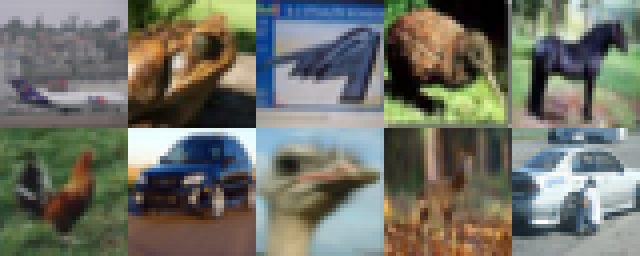

In [ ]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

Scary! But not too bad once we break it down. We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

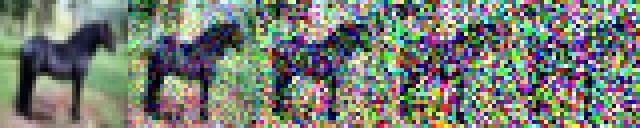

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
  var = gather(beta, t) # βt I
  eps = torch.randn_like(xtm1) # Noise shaped like xtm1
  return mean + (var ** 0.5) * eps

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))
  
  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37. 

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$. 

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$

Again, the code is far less scary:

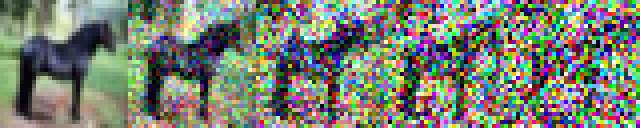

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

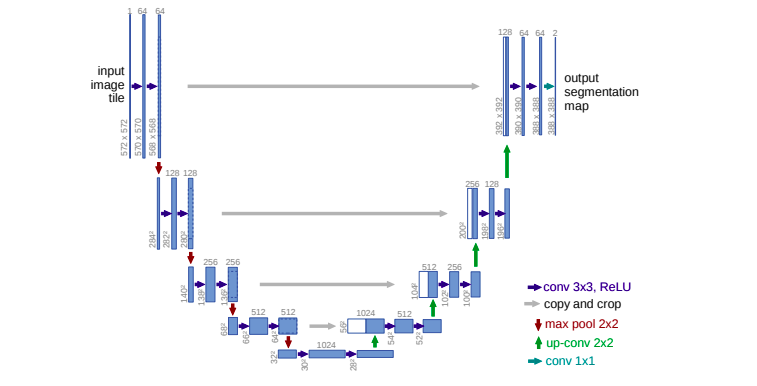

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers. 

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks. 

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
#@title Unet Definition
import math
import torch
import torch.nn as nn


def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   # b,hw,c
        k = k.reshape(b, c, h*w)  # b,c,hw
        w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
        # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x+h_


class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        ch, out_ch, ch_mult = config.model.ch, config.model.out_ch, tuple(config.model.ch_mult)
        num_res_blocks = config.model.num_res_blocks
        attn_resolutions = config.model.attn_resolutions
        dropout = config.model.dropout
        in_channels = config.model.in_channels
        resolution = config.data.image_size
        resamp_with_conv = config.model.resamp_with_conv
        num_timesteps = config.diffusion.num_diffusion_timesteps
        
        if config.model.type == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))
        
        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x, t):
        assert x.shape[2] == x.shape[3] == self.resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

Config

In [ ]:
from types import SimpleNamespace
args={
    'data':
        {'dataset': '',
        'image_size': 32,
        'channels': 3,
        'logit_transform': False,
        'uniform_dequantization': False,
        'gaussian_dequantization': False,
        'random_flip': True,
        'rescaled': True,
        'num_workers': True,},

    'model':
        {'type': "simple",
        'in_channels': 3,
        'out_ch': 3,
        'ch': 128,
        'ch_mult': [1, 2, 2, 2],
        'num_res_blocks': 2,
        'attn_resolutions': [16, ],
        'dropout': 0.1,
        'var_type': 'fixedlarge',
        'ema_rate': 0.9999,
        'ema': True,
        'resamp_with_conv': True,},

    'diffusion':
        {'beta_schedule': 'linear',
        'beta_start': 0.0001,
        'beta_end': 0.02,
        'num_diffusion_timesteps': 1000,},

    'training':
        {'batch_size': 128,
        'n_epochs': 100,
        'n_iters': 5000000,
        'snapshot_freq': 5000,
        'validation_freq': 2000,},

    'sampling':
        {'batch_size': 64,
        'last_only': True,},

    'optim':
        {'weight_decay': 0.000,
        'optimizer': "Adam",
        'lr': 0.0002,
        'beta1': 0.9,
        'amsgrad': False,
        'eps': 0.00000001,
        'grad_clip': 1.0,
        }
      }

temp={}
for k,v in args.items():
  temp[k]=SimpleNamespace(**v)

config = SimpleNamespace(**temp)

In [ ]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = Model(config)

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## EMA

In [ ]:
import torch.nn as nn

class EMAHelper(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module, nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(
                inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy = nn.DataParallel(module_copy)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        # module_copy = copy.deepcopy(module)
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

相比 DDPM 训练改进：
（1）增加 EMA
（2）对称采样 t

In [ ]:
# Create the model
unet = Model(config).cuda()

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # also returns noise

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

dataset = cifar10['train']#.select(range(10000)) # to use a 10k subset for demo

# optimizer
optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer


# EMA
if config.model.ema:
  ema_helper = EMAHelper(mu=config.model.ema_rate)
  ema_helper.register(unet)
else:
  ema_helper = None

start_epoch=0
for epoch in range(start_epoch, config.training.n_epochs):
  for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
    ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)] # Fetch some images
    tims = [img_to_tensor(im).cuda() for im in ims] # Convert to tensors
    x0 = torch.cat(tims) # Combine into a batch
    
    # DDPM
    # t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda() # Random 't's 
    
    t= torch.randint(low=0, high=n_steps, size=(batch_size // 2 + 1,)).cuda()
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size]

    xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
    pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
    loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
    losses.append(loss.item()) # Store the loss for later viewing
    optim.zero_grad() # Zero the gradients
    loss.backward() # Backpropagate the loss (computes and store gradients)
    optim.step() # Update the network parameters (using those gradients)
    
    if config.model.ema:
      ema_helper.update(unet)


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

NB: You'd typically create a dataloader to run through a dataset in batches like we did above, but I couldn't remember the syntax and forgot to fix it! Hopefully the way I did it here is clear enough :)

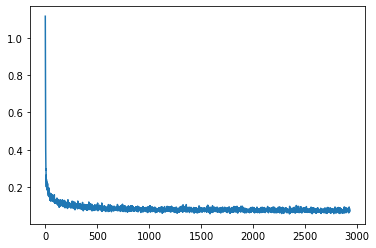

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

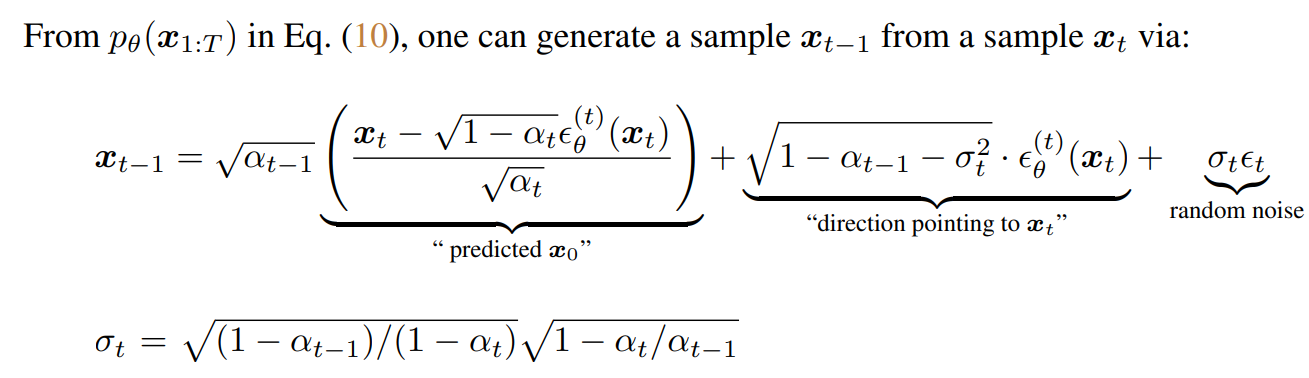

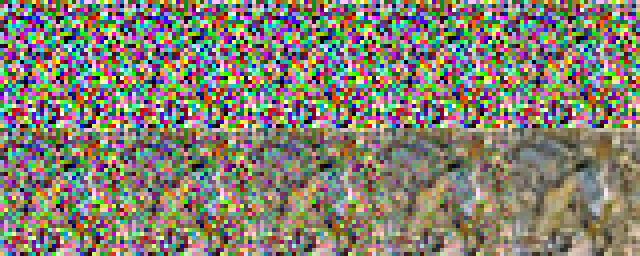

In [ ]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a
    

eta=0.0
timesteps=50
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
skip = n_steps // timesteps
seq = range(0, n_steps, skip)

def p_xt(xt, noise, t,next_t):
  at = compute_alpha(beta, t.long())
  at_next = compute_alpha(beta, next_t.long())
  x0_t = (xt - noise * (1 - at).sqrt()) / at.sqrt()
  c1 = (eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt())
  c2 = ((1 - at_next) - c1 ** 2).sqrt()
  eps = torch.randn(xt.shape, device=xt.device)
  xt_next = at_next.sqrt() * x0_t + c1 * eps + c2 * noise
  return xt_next

ims=[]
n = x.size(0)
seq_next = [-1] + list(seq[:-1])
for i, j in zip(reversed(seq), reversed(seq_next)):
  t = (torch.ones(n) * i).to(x.device)
  next_t = (torch.ones(n) * j).to(x.device)
  with torch.no_grad():
      pred_noise = unet(x, t)
      x = p_xt(x, pred_noise, t, next_t)
      if i%10 == 0:
        ims.append(tensor_to_image(x.cpu()))

# draw
image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

We're only training here with 100 noise steps, and perhaps the model mostly sees images with at least a little bit of structure to them. If we start with a half-noised image can it at least 'fix' it back to something like the original?

torch.Size([1, 3, 32, 32])


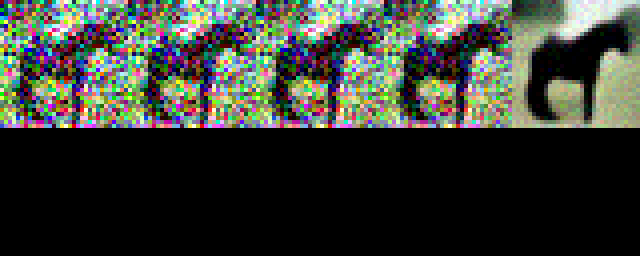

In [ ]:
eta=0.0
timesteps=50
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise


horse = cifar10['train'][4]['img']
x0 = img_to_tensor(horse)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(1)]).type(torch.FloatTensor).cuda()
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)


skip = n_steps // timesteps
seq = range(50, n_steps, skip)

def p_xt(xt, noise, t,next_t):
  at = compute_alpha(beta, t.long())
  at_next = compute_alpha(beta, next_t.long())
  x0_t = (xt - noise * (1 - at).sqrt()) / at.sqrt()
  c1 = (eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt())
  c2 = ((1 - at_next) - c1 ** 2).sqrt()
  eps = torch.randn(xt.shape, device=xt.device)
  xt_next = at_next.sqrt() * x0_t + c1 * eps + c2 * noise
  return xt_next

ims=[]
n = x.size(0)
seq_next = [-1] + list(seq[:-1])
for i, j in zip(reversed(seq), reversed(seq_next)):
  t = (torch.ones(n) * i).cuda()
  next_t = (torch.ones(n) * j).cuda()
  with torch.no_grad():
      pred_noise = unet(x, t)
      x = p_xt(x, pred_noise, t, next_t)
      if i%5 == 0:
        ims.append(tensor_to_image(x.cpu()))

# draw
image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)